In [1]:
!pip install torch
!pip install torch-geometric
!pip install pysmiles
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 68.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data
from google.colab import drive
drive.mount('/content/gdrive')

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)

Mounted at /content/gdrive


# Dataset
1. AqSolDB (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
2. OChem (https://ochem.eu/login/show.do?render-mode=full)
3. BigSolDB (https://zenodo.org/records/6984601)



# BigSolDB

In [4]:
# BigSolDB.csv

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('gdrive/My Drive/Base_GNN_Solubility/BigSolDB.csv')
# df = df[df['Solvent']=='water']
df['Solubility'] = np.log(df['Solubility'])
df = df.reset_index(drop=True)

X_smiles = list(df['SMILES']) #get smiles strings from file
X_smiles_Solvent = list(df['SMILES_Solvent'])
Y = np.asarray(df['Solubility']) #get solubility values from file

# columns_to_normalize = [
#     "MolWt",
#     "MolLogP",
#     "MolMR",
#     "HeavyAtomCount",
#     "NumHAcceptors",
#     "NumHDonors",
#     "NumHeteroatoms",
#     "NumRotatableBonds"]

columns_to_normalize = [
    "T,K"]

scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])*100


# def is_valid_smiles(smiles):
#     """Check if a SMILES string is valid."""
#     try:
#         mol = Chem.MolFromSmiles(smiles)
#         return mol is not None
#     except Exception:
#         return False

# # Remove invalid solute SMILES
# df = df[df['SMILES'].apply(is_valid_smiles)]

# # Remove invalid solvent SMILES
# df = df[df['SMILES_Solvent'].apply(is_valid_smiles)]
# df


df = df[~df['SMILES'].str.contains('-')]
df = df[~df['SMILES_Solvent'].str.contains('-')]
df.reset_index(drop=True, inplace=True)
df


,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source
0,ON(Cc1ccccc1)Cc1ccccc1,18.7500,-6.675850,methanol,CO,10.1021/acs.jced.9b01028
1,ON(Cc1ccccc1)Cc1ccccc1,22.5000,-6.369509,methanol,CO,10.1021/acs.jced.9b01028
2,ON(Cc1ccccc1)Cc1ccccc1,25.1875,-6.168679,methanol,CO,10.1021/acs.jced.9b01028
3,ON(Cc1ccccc1)Cc1ccccc1,28.6875,-5.892525,methanol,CO,10.1021/acs.jced.9b01028
4,ON(Cc1ccccc1)Cc1ccccc1,31.1875,-5.705684,methanol,CO,10.1021/acs.jced.9b01028
...,...,...,...,...,...,...
42014,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,44.6875,-4.112916,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
42015,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,46.8125,-3.967536,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
42016,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,48.4375,-3.860855,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
42017,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,50.0625,-3.753738,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012


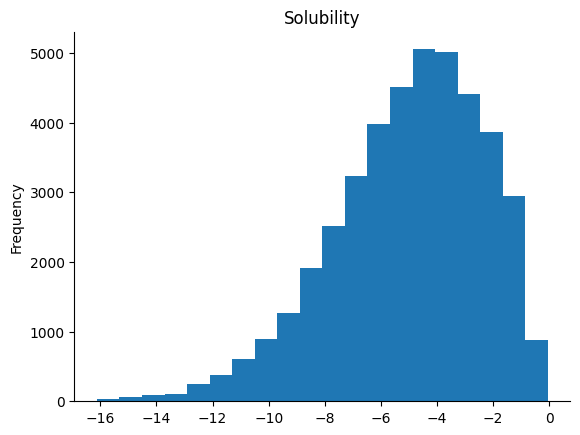

In [17]:
# @title Solubility

from matplotlib import pyplot as plt
df['Solubility'].plot(kind='hist', bins=20, title='Solubility')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source
0,ON(Cc1ccccc1)Cc1ccccc1,18.7500,-6.675850,methanol,CO,10.1021/acs.jced.9b01028
1,ON(Cc1ccccc1)Cc1ccccc1,22.5000,-6.369509,methanol,CO,10.1021/acs.jced.9b01028
2,ON(Cc1ccccc1)Cc1ccccc1,25.1875,-6.168679,methanol,CO,10.1021/acs.jced.9b01028
3,ON(Cc1ccccc1)Cc1ccccc1,28.6875,-5.892525,methanol,CO,10.1021/acs.jced.9b01028
4,ON(Cc1ccccc1)Cc1ccccc1,31.1875,-5.705684,methanol,CO,10.1021/acs.jced.9b01028
...,...,...,...,...,...,...
54268,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,44.6875,-4.112916,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
54269,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,46.8125,-3.967536,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
54270,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,48.4375,-3.860855,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
54271,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,50.0625,-3.753738,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012


In [5]:
import os.path as osp
import random
import pandas as pd
import torch
from rdkit import Chem
from tqdm import tqdm
from torch_geometric.data import Data

class GenFeatures:
    def __init__(self):
        self.symbols = [
            'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br',
            'Te', 'I', 'At', 'other'
        ]
        self.hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED,
            'other',
        ]
        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]

    def __call__(self, smiles, i, y):
        # Generate features for the molecule
        data = Data()
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)

        xs = []
        for atom in mol.GetAtoms():
            symbol = [0.] * len(self.symbols)
            atom_symbol = atom.GetSymbol()
            if atom_symbol in self.symbols:
                symbol[self.symbols.index(atom_symbol)] = 1.
            else:
                symbol[-1] = 1.  # Mark as 'other'

            degree = [0.] * 6
            atom_degree = atom.GetDegree()
            if atom_degree < len(degree):
                degree[atom_degree] = 1.

            formal_charge = atom.GetFormalCharge()
            radical_electrons = atom.GetNumRadicalElectrons()
            hybridization = [0.] * len(self.hybridizations)
            try:
                hybridization[self.hybridizations.index(atom.GetHybridization())] = 1.
            except ValueError:
                hybridization[-1] = 1.  # Default to 'other'

            aromaticity = 1. if atom.GetIsAromatic() else 0.
            hydrogens = [0.] * 5
            total_hydrogens = atom.GetTotalNumHs()
            if total_hydrogens < len(hydrogens):
                hydrogens[total_hydrogens] = 1.
            else:
                hydrogens[-1] = 1.

            chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
            chirality_type = [0.] * 2
            if atom.HasProp('_CIPCode'):
                cip_code = atom.GetProp('_CIPCode')
                if cip_code in ['R', 'S']:
                    chirality_type[['R', 'S'].index(cip_code)] = 1.

            x = torch.tensor(symbol + degree + [formal_charge] +
                             [radical_electrons] + hybridization +
                             [aromaticity] + hydrogens + [chirality] +
                             chirality_type)
            xs.append(x)

        data.x = torch.stack(xs, dim=0)
        data.y = torch.tensor(y, dtype=torch.float)

        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
            conjugation = 1. if bond.GetIsConjugated() else 0.
            ring = 1. if bond.IsInRing() else 0.
            stereo = [0.] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor(
                [single, double, triple, aromatic, conjugation, ring] + stereo)

            edge_attrs += [edge_attr, edge_attr]

        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)

        graph_level_features = pd.to_numeric(df.iloc[i, :][["T,K"]], errors='coerce').fillna(0).values
        graph_level_features = torch.tensor(graph_level_features, dtype=torch.float)
        data.graph_level_features = graph_level_features

        return data


# Assuming df contains columns 'SMILES' for solutes and 'SMILES_Solvent' for solvents
X_smiles = list(df['SMILES'])
X_smiles_solvent = list(df['SMILES_Solvent'])
Y_solute = list(df['Solubility'])  # Your target for solutes
Y_solvent = list(df['Solubility'])   # Your target for solvents

pre_transform = GenFeatures()

data_solute = []
data_solvent = []

# Process solutes
for i, smiles in tqdm(enumerate(X_smiles), total=len(X_smiles)):
    try:
        node_edge_featurization = pre_transform(smiles, i, Y_solute[i])
        data_solute.append(node_edge_featurization)
    except Exception as e:
        print(f"Error processing solute {smiles}: {e}")

# Process solvents
for i, smiles in tqdm(enumerate(X_smiles_solvent), total=len(X_smiles_solvent)):
    try:
        node_edge_featurization = pre_transform(smiles, i, Y_solvent[i])
        data_solvent.append(node_edge_featurization)
    except Exception as e:
        print(f"Error processing solvent {smiles}: {e}")

# Shuffle and split the data
combined_data = list(zip(data_solute, data_solvent))
random.shuffle(combined_data)
train_size = int(len(combined_data) * 0.6)
val_size = int(len(combined_data) * 0.2)
train_data = combined_data[:train_size]
val_data = combined_data[train_size:train_size + val_size]
test_data = combined_data[train_size + val_size:]

print(f"Training data: {len(train_data)}, Validation data: {len(val_data)}, Test data: {len(test_data)}")


100%|██████████| 42019/42019 [01:00<00:00, 697.66it/s]


Training data: 25211, Validation data: 8403, Test data: 8405


In [ ]:
combined_data[0]

(Data(x=[42, 41], y=-5.921938419342041, edge_index=[2, 90], edge_attr=[90, 10], graph_level_features=[1]),
 Data(x=[27, 41], y=-5.921938419342041, edge_index=[2, 52], edge_attr=[52, 10], graph_level_features=[1]))

In [ ]:
combined_data[1]

(Data(x=[23, 41], y=-3.424978017807007, edge_index=[2, 44], edge_attr=[44, 10], graph_level_features=[1]),
 Data(x=[3, 41], y=-3.424978017807007, edge_index=[2, 4], edge_attr=[4, 10], graph_level_features=[1]))

In [ ]:
combined_data[2]

(Data(x=[35, 41], y=-9.783218383789062, edge_index=[2, 74], edge_attr=[74, 10], graph_level_features=[1]),
 Data(x=[15, 41], y=-9.783218383789062, edge_index=[2, 28], edge_attr=[28, 10], graph_level_features=[1]))

In [ ]:
combined_data[2][0].y

tensor(-9.7832)

# General Model for both Modeling Solvent-Solute Pair


In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))
        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        # return self.lin2(out)
        return out


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


class Solute_Solvent_Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers, num_timesteps, dropout):
        super(Solute_Solvent_Model, self).__init__()
        self.attentive_fp = AttentiveFP(in_channels, hidden_channels, out_channels, edge_dim, num_layers, num_timesteps, dropout)
        self.linear = torch.nn.Linear(hidden_channels*2+1, 1)

    def forward(self, combined_data):
        data_solute, data_solvent = combined_data
        x1, edge_index1, edge_attr1, batch1, graph_level_features = data_solute.x, data_solute.edge_index, data_solute.edge_attr, torch.zeros(data_solute.x.size(0), dtype=torch.long), data_solute.graph_level_features
        out = self.attentive_fp(x1, edge_index1, edge_attr1, batch1)
        x2, edge_index2, edge_attr2, batch2 = data_solvent.x, data_solvent.edge_index, data_solvent.edge_attr, torch.zeros(data_solvent.x.size(0), dtype=torch.long)
        x1 = self.attentive_fp(x1, edge_index1, edge_attr1, batch1)
        x2 = self.attentive_fp(x2, edge_index2, edge_attr2, batch2)


        x = torch.cat((x1, x2), dim=1)
        # print(x.shape)
        x = torch.concat((x, graph_level_features.unsqueeze(0)), dim = -1)
        # print(x.shape)
        x = self.linear(x)
        # print(x.shape)

        return x

    def __repr__(self):
        return self.attentive_fp.__repr__()



#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Solute_Solvent_Model(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
# # model = Net().to(device) #create network and send to the device memory
# model = AttentiveFP(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    # random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train_data):  # Go over each training point
        data = d # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data)  # Evaluate data point

        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train_data)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val_data:
            data = d  # Send data to device
            out = model(data)  # Evaluate data point
            loss = mae_loss(out.squeeze(), data[0].y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val_data)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))


100%|██████████| 25211/25211 [10:24<00:00, 40.39it/s]


Epoch: 001, Average MAE: 1.77998
Validation MAE: 1.59979
Model improved! Saving model...


100%|██████████| 25211/25211 [09:35<00:00, 43.78it/s]


Epoch: 002, Average MAE: 1.48991
Validation MAE: 1.37517
Model improved! Saving model...


100%|██████████| 25211/25211 [09:31<00:00, 44.12it/s]


Epoch: 003, Average MAE: 1.36794
Validation MAE: 1.31930
Model improved! Saving model...


100%|██████████| 25211/25211 [09:43<00:00, 43.19it/s]


Epoch: 004, Average MAE: 1.30199
Validation MAE: 1.28751
Model improved! Saving model...


100%|██████████| 25211/25211 [09:44<00:00, 43.17it/s]


Epoch: 005, Average MAE: 1.25870
Validation MAE: 1.24200
Model improved! Saving model...


100%|██████████| 25211/25211 [09:32<00:00, 44.07it/s]


Epoch: 006, Average MAE: 1.23924
Validation MAE: 1.17676
Model improved! Saving model...


100%|██████████| 25211/25211 [09:22<00:00, 44.84it/s]


Epoch: 007, Average MAE: 1.19571
Validation MAE: 1.16288
Model improved! Saving model...


100%|██████████| 25211/25211 [09:28<00:00, 44.33it/s]


Epoch: 008, Average MAE: 1.19201
Validation MAE: 1.15310
Model improved! Saving model...


100%|██████████| 25211/25211 [09:17<00:00, 45.21it/s]


Epoch: 009, Average MAE: 1.18790
Validation MAE: 1.13862
Model improved! Saving model...


100%|██████████| 25211/25211 [09:12<00:00, 45.65it/s]


Epoch: 010, Average MAE: 1.23368
Validation MAE: 1.38566


100%|██████████| 25211/25211 [09:23<00:00, 44.73it/s]


Epoch: 011, Average MAE: 1.19350
Validation MAE: 1.15082


100%|██████████| 25211/25211 [09:13<00:00, 45.58it/s]


Epoch: 012, Average MAE: 1.15947
Validation MAE: 1.16322


100%|██████████| 25211/25211 [09:14<00:00, 45.49it/s]


Epoch: 013, Average MAE: 1.14381
Validation MAE: 1.15293


100%|██████████| 25211/25211 [09:21<00:00, 44.90it/s]


Epoch: 014, Average MAE: 1.14098
Validation MAE: 1.11698
Model improved! Saving model...


100%|██████████| 25211/25211 [09:20<00:00, 44.97it/s]


Epoch: 015, Average MAE: 1.10936
Validation MAE: 1.09034
Model improved! Saving model...


100%|██████████| 25211/25211 [09:27<00:00, 44.42it/s]


Epoch: 016, Average MAE: 1.10917
Validation MAE: 1.11368


  1%|          | 206/25211 [00:04<09:25, 44.24it/s]

In [8]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))
        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        # return self.lin2(out)
        return out


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


class Solute_Solvent_Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers, num_timesteps, dropout):
        super(Solute_Solvent_Model, self).__init__()
        self.attentive_fp = AttentiveFP(in_channels, hidden_channels, out_channels, edge_dim, num_layers, num_timesteps, dropout)
        self.linear = torch.nn.Linear(hidden_channels*2+1, 1)

    def forward(self, combined_data):
        data_solute, data_solvent = combined_data
        x1, edge_index1, edge_attr1, batch1, graph_level_features = data_solute.x, data_solute.edge_index, data_solute.edge_attr, torch.zeros(data_solute.x.size(0), dtype=torch.long), data_solute.graph_level_features
        out = self.attentive_fp(x1, edge_index1, edge_attr1, batch1)
        x2, edge_index2, edge_attr2, batch2 = data_solvent.x, data_solvent.edge_index, data_solvent.edge_attr, torch.zeros(data_solvent.x.size(0), dtype=torch.long)
        x1 = self.attentive_fp(x1, edge_index1, edge_attr1, batch1)
        x2 = self.attentive_fp(x2, edge_index2, edge_attr2, batch2)


        x = torch.cat((x1, x2), dim=1)
        # print(x.shape)
        x = torch.concat((x, graph_level_features.unsqueeze(0)), dim = -1)
        # print(x.shape)
        x = self.linear(x)
        # print(x.shape)

        return x

    def __repr__(self):
        return self.attentive_fp.__repr__()



#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Solute_Solvent_Model(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)

mae_loss = nn.L1Loss()

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))


Test MAE: 1.08561
R-squared: 0.66814


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer


model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    # random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train_data):  # Go over each training point
        data = d # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data)  # Evaluate data point

        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train_data)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val_data:
            data = d  # Send data to device
            out = model(data)  # Evaluate data point
            loss = mae_loss(out.squeeze(), data[0].y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val_data)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 25211/25211 [10:15<00:00, 40.98it/s]


Epoch: 001, Average MAE: 1.39086
Validation MAE: 1.24778
Model improved! Saving model...


100%|██████████| 25211/25211 [09:40<00:00, 43.40it/s]


Epoch: 002, Average MAE: 1.13557
Validation MAE: 1.04414
Model improved! Saving model...


100%|██████████| 25211/25211 [10:30<00:00, 39.96it/s]


Epoch: 003, Average MAE: 1.11370
Validation MAE: 1.07055


100%|██████████| 25211/25211 [10:44<00:00, 39.13it/s]


Epoch: 004, Average MAE: 1.13918
Validation MAE: 1.12707


100%|██████████| 25211/25211 [10:40<00:00, 39.35it/s]


Epoch: 005, Average MAE: 1.12720
Validation MAE: 1.09328


100%|██████████| 25211/25211 [09:28<00:00, 44.34it/s]


Epoch: 006, Average MAE: 1.14847
Validation MAE: 1.07197


100%|██████████| 25211/25211 [09:28<00:00, 44.38it/s]


Epoch: 007, Average MAE: 1.11145
Validation MAE: 1.12070


100%|██████████| 25211/25211 [09:11<00:00, 45.71it/s]


Epoch: 008, Average MAE: 1.11606
Validation MAE: 1.03730
Model improved! Saving model...


100%|██████████| 25211/25211 [09:16<00:00, 45.30it/s]


Epoch: 009, Average MAE: 1.10212
Validation MAE: 1.06518


100%|██████████| 25211/25211 [09:06<00:00, 46.16it/s]


Epoch: 010, Average MAE: 1.09697
Validation MAE: 1.04174


100%|██████████| 25211/25211 [09:03<00:00, 46.41it/s]


Epoch: 011, Average MAE: 1.08802
Validation MAE: 1.09026


100%|██████████| 25211/25211 [09:02<00:00, 46.49it/s]


Epoch: 012, Average MAE: 1.08603
Validation MAE: 1.13592


 80%|███████▉  | 20062/25211 [07:17<01:52, 45.82it/s]


KeyboardInterrupt: 

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))
        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


class Solute_Solvent_Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers, num_timesteps, dropout):
        super(Solute_Solvent_Model, self).__init__()
        self.attentive_fp = AttentiveFP(in_channels, hidden_channels, out_channels, edge_dim, num_layers, num_timesteps, dropout)
        self.linear = torch.nn.Linear(out_channels*2+1, 1)

    def forward(self, combined_data):
        data_solute, data_solvent = combined_data
        x1, edge_index1, edge_attr1, batch1, graph_level_features = data_solute.x, data_solute.edge_index, data_solute.edge_attr, torch.zeros(data_solute.x.size(0), dtype=torch.long), data_solute.graph_level_features
        out = self.attentive_fp(x1, edge_index1, edge_attr1, batch1)
        x2, edge_index2, edge_attr2, batch2 = data_solvent.x, data_solvent.edge_index, data_solvent.edge_attr, torch.zeros(data_solvent.x.size(0), dtype=torch.long)
        x1 = self.attentive_fp(x1, edge_index1, edge_attr1, batch1)
        x2 = self.attentive_fp(x2, edge_index2, edge_attr2, batch2)


        x = torch.cat((x1, x2), dim=1)
        x = torch.concat((x, graph_level_features.unsqueeze(0)), dim = -1)
        x = self.linear(x)

        return x

    def __repr__(self):
        return self.attentive_fp.__repr__()



#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Solute_Solvent_Model(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
# # model = Net().to(device) #create network and send to the device memory
# model = AttentiveFP(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    # random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train_data):  # Go over each training point
        data = d # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data)  # Evaluate data point

        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train_data)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val_data:
            data = d  # Send data to device
            out = model(data)  # Evaluate data point
            loss = mae_loss(out.squeeze(), data[0].y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val_data)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)
print('R-squared: {:.5f}'.format(r2))

100%|██████████| 25211/25211 [13:09<00:00, 31.95it/s]


Epoch: 001, Average MAE: 1.92067
Validation MAE: 1.62651
Model improved! Saving model...


100%|██████████| 25211/25211 [11:36<00:00, 36.18it/s]


Epoch: 002, Average MAE: 1.60857
Validation MAE: 1.48909
Model improved! Saving model...


100%|██████████| 25211/25211 [10:49<00:00, 38.83it/s]


Epoch: 003, Average MAE: 1.49596
Validation MAE: 1.46925
Model improved! Saving model...


100%|██████████| 25211/25211 [10:33<00:00, 39.77it/s]


Epoch: 004, Average MAE: 1.41560
Validation MAE: 1.28585
Model improved! Saving model...


100%|██████████| 25211/25211 [10:39<00:00, 39.44it/s]


Epoch: 005, Average MAE: 1.37840
Validation MAE: 1.28561
Model improved! Saving model...


100%|██████████| 25211/25211 [11:01<00:00, 38.09it/s]


Epoch: 006, Average MAE: 1.35123
Validation MAE: 1.29248


100%|██████████| 25211/25211 [11:33<00:00, 36.33it/s]


Epoch: 007, Average MAE: 1.31783
Validation MAE: 1.28501
Model improved! Saving model...


100%|██████████| 25211/25211 [11:03<00:00, 38.01it/s]


Epoch: 008, Average MAE: 1.33488
Validation MAE: 1.29817


100%|██████████| 25211/25211 [11:20<00:00, 37.04it/s]


Epoch: 009, Average MAE: 1.32654
Validation MAE: 1.27067
Model improved! Saving model...


100%|██████████| 25211/25211 [11:11<00:00, 37.54it/s]


Epoch: 010, Average MAE: 1.29366
Validation MAE: 1.26806
Model improved! Saving model...


100%|██████████| 25211/25211 [10:44<00:00, 39.14it/s]


Epoch: 011, Average MAE: 1.29045
Validation MAE: 1.21578
Model improved! Saving model...


100%|██████████| 25211/25211 [11:04<00:00, 37.92it/s]


Epoch: 012, Average MAE: 1.25838
Validation MAE: 1.19925
Model improved! Saving model...


100%|██████████| 25211/25211 [10:47<00:00, 38.93it/s]


Epoch: 013, Average MAE: 1.25608
Validation MAE: 1.17875
Model improved! Saving model...


100%|██████████| 25211/25211 [10:45<00:00, 39.06it/s]


Epoch: 014, Average MAE: 1.25330
Validation MAE: 1.20199


100%|██████████| 25211/25211 [10:58<00:00, 38.29it/s]


Epoch: 015, Average MAE: 1.24760
Validation MAE: 1.19503


100%|██████████| 25211/25211 [11:31<00:00, 36.44it/s]


Epoch: 016, Average MAE: 1.21200
Validation MAE: 1.23582


100%|██████████| 25211/25211 [11:19<00:00, 37.09it/s]


Epoch: 017, Average MAE: 1.20149
Validation MAE: 1.13093
Model improved! Saving model...


100%|██████████| 25211/25211 [11:15<00:00, 37.35it/s]


Epoch: 018, Average MAE: 1.17836
Validation MAE: 1.16561


 33%|███▎      | 8315/25211 [03:41<06:56, 40.61it/s]

In [9]:
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    # random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train_data):  # Go over each training point
        data = d # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data)  # Evaluate data point

        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train_data)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val_data:
            data = d  # Send data to device
            out = model(data)  # Evaluate data point
            loss = mae_loss(out.squeeze(), data[0].y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val_data)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 25211/25211 [09:36<00:00, 43.76it/s]


Epoch: 001, Average MAE: 1.44943
Validation MAE: 1.26110
Model improved! Saving model...


100%|██████████| 25211/25211 [09:10<00:00, 45.82it/s]


Epoch: 002, Average MAE: 1.22009
Validation MAE: 1.21032
Model improved! Saving model...


100%|██████████| 25211/25211 [09:28<00:00, 44.31it/s]


Epoch: 003, Average MAE: 1.19712
Validation MAE: 1.20192
Model improved! Saving model...


100%|██████████| 25211/25211 [09:13<00:00, 45.58it/s]


Epoch: 004, Average MAE: 1.19677
Validation MAE: 1.19407
Model improved! Saving model...


100%|██████████| 25211/25211 [09:14<00:00, 45.50it/s]


Epoch: 005, Average MAE: 1.17991
Validation MAE: 1.16129
Model improved! Saving model...


100%|██████████| 25211/25211 [09:05<00:00, 46.20it/s]


Epoch: 006, Average MAE: 1.18330
Validation MAE: 1.16967


100%|██████████| 25211/25211 [09:02<00:00, 46.50it/s]


Epoch: 007, Average MAE: 1.16457
Validation MAE: 1.13351
Model improved! Saving model...


100%|██████████| 25211/25211 [09:22<00:00, 44.85it/s]


Epoch: 008, Average MAE: 1.17222
Validation MAE: 1.16227


100%|██████████| 25211/25211 [10:10<00:00, 41.31it/s]


Epoch: 009, Average MAE: 1.18419
Validation MAE: 1.14097


100%|██████████| 25211/25211 [09:05<00:00, 46.25it/s]


Epoch: 010, Average MAE: 1.16564
Validation MAE: 1.13275
Model improved! Saving model...


100%|██████████| 25211/25211 [09:06<00:00, 46.12it/s]


Epoch: 011, Average MAE: 1.15826
Validation MAE: 1.16697


 63%|██████▎   | 15804/25211 [05:47<03:26, 45.49it/s]


KeyboardInterrupt: 

In [15]:
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    # random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train_data):  # Go over each training point
        data = d # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data)  # Evaluate data point

        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train_data)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val_data:
            data = d  # Send data to device
            out = model(data)  # Evaluate data point
            loss = mae_loss(out.squeeze(), data[0].y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val_data)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 25211/25211 [11:07<00:00, 37.74it/s]


Epoch: 001, Average MAE: 1.45148
Validation MAE: 1.23363
Model improved! Saving model...


100%|██████████| 25211/25211 [09:57<00:00, 42.16it/s]


Epoch: 002, Average MAE: 1.16940
Validation MAE: 1.11649
Model improved! Saving model...


100%|██████████| 25211/25211 [10:29<00:00, 40.05it/s]


Epoch: 003, Average MAE: 1.15229
Validation MAE: 1.09312
Model improved! Saving model...


100%|██████████| 25211/25211 [10:11<00:00, 41.23it/s]


Epoch: 004, Average MAE: 1.12733
Validation MAE: 1.10043


100%|██████████| 25211/25211 [10:51<00:00, 38.72it/s]


Epoch: 005, Average MAE: 1.12822
Validation MAE: 1.08749
Model improved! Saving model...


100%|██████████| 25211/25211 [09:08<00:00, 45.97it/s]


Epoch: 006, Average MAE: 1.38769
Validation MAE: 1.39104


100%|██████████| 25211/25211 [09:15<00:00, 45.36it/s]


Epoch: 007, Average MAE: 1.32142
Validation MAE: 1.20813


100%|██████████| 25211/25211 [09:23<00:00, 44.75it/s]


Epoch: 008, Average MAE: 1.23368
Validation MAE: 1.21758


100%|██████████| 25211/25211 [09:30<00:00, 44.22it/s]


Epoch: 009, Average MAE: 1.24996
Validation MAE: 1.18082


 56%|█████▌    | 14155/25211 [05:09<04:01, 45.75it/s]


KeyboardInterrupt: 

# no T

In [10]:
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

Test MAE: 1.15364
R-squared: 0.65158


# W. T

In [16]:
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

Test MAE: 1.09993
R-squared: 0.66613


# W. T (version 2)

In [11]:
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test_data:
        data = d
        out = model(data)  # Evaluate test point
        actual_values = data[0].y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data[0].y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test_data)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

Test MAE: 1.06140
R-squared: 0.67394


# AttentiveFP (with edge features)

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))
        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Proposed New Architecture

#replace GAT by SAGEConv

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GCNConv, GraphConv, SAGEConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = SAGEConv(hidden_channels, hidden_channels)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = SAGEConv(hidden_channels, hidden_channels)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Improved GRU

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax

# class EnhancedGRUCell(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EnhancedGRUCell, self).__init__()
#         self.gru = nn.GRUCell(input_size, hidden_size)
#         self.layer_norm = nn.LayerNorm(hidden_size)

#     def reset_parameters(self):
#         self.gru.reset_parameters()  # Reset parameters of the underlying GRU

#     def forward(self, input: Tensor, hidden: Tensor) -> Tensor:
#         hidden = self.gru(input, hidden)
#         return self.layer_norm(hidden)


class EnhancedGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EnhancedGRUCell, self).__init__()
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        # self.dropout = nn.Dropout(dropout_rate)

    def reset_parameters(self):
        self.gru.reset_parameters()

    def forward(self, input: Tensor, hidden: Tensor) -> Tensor:
        new_hidden = self.gru(input, hidden)
        new_hidden = self.layer_norm(new_hidden + hidden)  # Residual connection
        return new_hidden



class AttentiveFP(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = nn.Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.gru = EnhancedGRUCell(hidden_channels, hidden_channels)  # Use enhanced GRU

        self.atom_convs = nn.ModuleList()
        self.atom_grus = nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout, add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(EnhancedGRUCell(hidden_channels, hidden_channels))  # Use enhanced GRU

        self.mol_conv = GATConv(hidden_channels, hidden_channels, dropout=dropout, add_self_loops=False, negative_slope=0.01)
        self.mol_gru = EnhancedGRUCell(hidden_channels, hidden_channels)  # Use enhanced GRU

        self.lin2 = nn.Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, batch: Tensor) -> Tensor:
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x)  # Use enhanced GRU
        x = F.relu(x)

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x)  # Use enhanced GRU
            x = F.relu(x)

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out)  # Use enhanced GRU
            out = F.relu(out)

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


# replace GRU by LSTM

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTMCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.lstm = LSTMCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_lstm = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_lstm.append(LSTMCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False
        self.mol_lstm = LSTMCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.lstm.reset_parameters()
        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            conv.reset_parameters()
            lstm.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_lstm.reset_parameters()
        self.lin2.reset_parameters()


    # def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
    #             batch: Tensor) -> Tensor:
    #     """"""  # noqa: D419
    #     # Atom Embedding:
    #     x = F.leaky_relu_(self.lin1(x))

    #     h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
    #     h = F.dropout(h, p=self.dropout, training=self.training)
    #     x = self.gru(h, x).relu_()

    #     for conv, gru in zip(self.atom_convs, self.atom_grus):
    #         h = conv(x, edge_index)
    #         h = F.elu(h)
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         x = gru(h, x).relu()

    #     # Molecule Embedding:
    #     row = torch.arange(batch.size(0), device=batch.device)
    #     edge_index = torch.stack([row, batch], dim=0)

    #     out = global_add_pool(x, batch).relu_()
    #     for t in range(self.num_timesteps):
    #         h = F.elu_(self.mol_conv((x, out), edge_index))
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         out = self.mol_gru(h, out).relu_()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)

        # Initialize hidden and cell states for the LSTM
        # hx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        # cx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        cx = x

        # # Using LSTMCell
        # hx, cx = self.lstm(h, (hx, cx))  # Update x with LSTM

        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x, cx = lstm(h, (x, cx))  # Update x with LSTM
            x = x.relu()

        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        cx = out

        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out, cx = self.mol_lstm(h, (out, cx))  # Update out with LSTM
            out = out.relu()
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


In [ ]:
from typing import Optional
from torch_geometric.transforms import GDC
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.graph_transform = GDC()
        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data, edge_attr,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        print(data.x.shape)
        print(data.edge_index.shape)
        new_data = self.graph_transform(data)
        x, edge_index = new_data.x, new_data.edge_index
        print(new_data.x.shape)
        print(new_data.edge_index.shape)
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

In [ ]:
from typing import Optional
from torch_geometric.transforms import GDC

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj) -> Tensor:
        # edge_updater_type: (x: Tensor)
        alpha = self.edge_updater(edge_index, x=x)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFPNew(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout
        self.graph_transform = myGDC()

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        # print(data.edge_index.shape)
        # new_data = self.graph_transform(data)

        # x, edge_index = new_data.x, new_data.edge_index
        # x = F.leaky_relu_(self.lin1(x))


      # Check if there are edges in the graph
        # print(data.edge_index.shape)
        if data.edge_index.size(1) == 0:
            # print("No edges found. Skipping graph diffusion.")
            x, edge_index = data.x, data.edge_index
            x = F.leaky_relu_(self.lin1(data.x))  # Apply linear transformation directly

        else:
            new_data = self.graph_transform(data)
            x, edge_index = new_data.x, new_data.edge_index
            x = F.leaky_relu_(self.lin1(x))

        # if data.edge_index.size(1) == 0:
        #     print("No edges found. Skipping graph diffusion.")
        #     x = F.leaky_relu_(self.lin1(data.x))
        #     return self.lin2(global_add_pool(x, batch))  # Return output directly

        # # Proceed with graph diffusion if edges exist
        # try:
        #     new_data = self.graph_transform(data)
        #     x, edge_index = new_data.x, new_data.edge_index
        #     # print("Transformed edge index shape:", edge_index.shape)

        #     # Apply the first linear transformation
        #     x = F.leaky_relu_(self.lin1(x))

        # except Exception as e:
        #     print("Error during graph transformation:", e)
        #     return None  # Handle appropriately



        h = F.elu_(self.gate_conv(x, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Replace GATConv by GINConv

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GINConv, TransformerConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = TransformerConv(32, 8, heads=4)

            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))


        self.mol_conv = TransformerConv(32, 8, heads=4)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels+8, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, graph_level_features,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

In [ ]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.lin = Linear(in_channels, in_channels)
        self.att = Parameter(torch.empty(1, in_channels))
        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        zeros(self.att)

    def forward(self, features: Tensor) -> Tensor:
        scores = (self.lin(features) * self.att).sum(dim=-1)  # Compute attention scores
        alpha = F.softmax(scores, dim=1)  # Compute softmax for attention weights
        return (features * alpha.unsqueeze(-1)).sum(dim=0)  # Weighted sum of features

In [ ]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.lin = Linear(in_channels, in_channels)
        self.att = Parameter(torch.empty(1, in_channels))
        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        zeros(self.att)

    def forward(self, features: Tensor) -> Tensor:
        scores = (self.lin(features) * self.att).sum(dim=-1)  # Compute attention scores
        # alpha = F.softmax(scores, dim=0)  # Compute softmax for attention weights
        alpha = F.softmax(scores, dim=0)
        return (features * alpha.unsqueeze(-1)).sum(dim=0)  # Weighted sum of features

from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout
        self.attention_layer = AttentionLayer(hidden_channels + 8)
        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels+8, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, graph_level_features,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)

        out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        out = self.attention_layer(out)
        # print(out.shape)
        out = F.dropout(out, p=self.dropout, training=self.training)

        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

In [ ]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.lin = Linear(in_channels, in_channels)
        self.att = Parameter(torch.empty(1, in_channels))
        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        zeros(self.att)

    def forward(self, features: Tensor) -> Tensor:
        scores = (self.lin(features) * self.att).sum(dim=-1)  # Compute attention scores
        # alpha = F.softmax(scores, dim=0)  # Compute softmax for attention weights
        alpha = F.softmax(scores, dim=0)
        return (features * alpha.unsqueeze(-1)).sum(dim=0)  # Weighted sum of features

from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout
        self.attention_layer = AttentionLayer(hidden_channels + 1)
        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels+1, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, graph_level_features,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)

        out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        out = self.attention_layer(out)
        # print(out.shape)
        out = F.dropout(out, p=self.dropout, training=self.training)

        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

In [ ]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.lin = Linear(in_channels, in_channels)
        self.att = Parameter(torch.empty(1, in_channels))
        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        zeros(self.att)

    def forward(self, features: Tensor) -> Tensor:
        scores = (self.lin(features) * self.att).sum(dim=-1)  # Compute attention scores
        # alpha = F.softmax(scores, dim=0)  # Compute softmax for attention weights
        alpha = F.softmax(scores, dim=0)
        return (features * alpha.unsqueeze(-1)).sum(dim=0)  # Weighted sum of features

from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        head: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.head = head
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout
        self.attention_layer = AttentionLayer(hidden_channels + 8)
        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATv2Conv(hidden_channels, int(hidden_channels/2), heads = head, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATv2Conv(hidden_channels, int(hidden_channels/2), heads = head,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels+1, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, graph_level_features,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)

        out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        out = self.attention_layer(out)
        # print(out.shape)
        out = F.dropout(out, p=self.dropout, training=self.training)

        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# AttentiveMolBERT

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.nn import GRUCell, Linear, Parameter
from torch_geometric.nn import GATConv, global_add_pool
from torch_geometric.utils import softmax
from torch_geometric.nn import MessagePassing

class GATEConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, edge_dim: int, dropout: float = 0.0):
        super().__init__(aggr='add', node_dim=0)
        self.dropout = dropout
        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))
        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)
        self.bias = Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.xavier_uniform_(self.lin2.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        alpha = self.edge_update(edge_index, x=x, edge_attr=edge_attr)
        out = self.propagate(edge_index, x=x, alpha=alpha) + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor, index: Tensor, ptr: OptTensor, size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = F.leaky_relu_(alpha_j + alpha_i)
        alpha = softmax(alpha, index, ptr, size_i)
        return F.dropout(alpha, p=self.dropout, training=self.training)

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveMolBERT(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, edge_dim: int, num_layers: int, num_timesteps: int, dropout: float = 0.0):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)
        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = nn.ModuleList()
        for _ in range(num_layers):
            self.atom_convs.append(GATConv(hidden_channels, hidden_channels, dropout=dropout, add_self_loops=False))

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        for conv in self.atom_convs:
            conv.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, batch: Tensor) -> Tensor:
        # Atom Embedding
        x = F.leaky_relu_(self.lin1(x))
        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv in self.atom_convs:
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = h + x  # Residual connection

        out = global_add_pool(x, batch).relu_()
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


# Featurization for AttentiveFP


In [ ]:
# import os.path as osp
# from math import sqrt
# import torch
# import torch.nn.functional as F
# from rdkit import Chem
# from torch_geometric.datasets import MoleculeNet
# from torch_geometric.loader import DataLoader
# from torch_geometric.nn.models import AttentiveFP

# class GenFeatures:
#     def __init__(self):
#         # self.symbols = [
#         #     'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br',
#         #     'Te', 'I', 'At', 'other'
#         # ]

#         self.symbols = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',
#             'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
#             'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
#             'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
#             'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
#             'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C', 'other']

#         self.hybridizations = [
#             Chem.rdchem.HybridizationType.S,
#             Chem.rdchem.HybridizationType.SP,
#             Chem.rdchem.HybridizationType.SP2,
#             Chem.rdchem.HybridizationType.SP3,
#             Chem.rdchem.HybridizationType.SP3D,
#             Chem.rdchem.HybridizationType.SP3D2,
#             Chem.rdchem.HybridizationType.UNSPECIFIED,
#             'other',
#         ]



#         self.stereos = [
#             Chem.rdchem.BondStereo.STEREONONE,
#             Chem.rdchem.BondStereo.STEREOANY,
#             Chem.rdchem.BondStereo.STEREOZ,
#             Chem.rdchem.BondStereo.STEREOE,
#         ]

#     def __call__(self, smiles, i):
#         # Generate AttentiveFP features
#         data = Data()
#         mol = Chem.MolFromSmiles(smiles)
#         mol = Chem.AddHs(mol)

#         xs = []

#         for atom in mol.GetAtoms():
#           # Initialize the symbol vector
#           symbol = [0.] * len(self.symbols)

#           # Handle atom symbol
#           atom_symbol = atom.GetSymbol()
#           if atom_symbol in self.symbols:
#               symbol[self.symbols.index(atom_symbol)] = 1.
#           else:
#               print(f"Unrecognized element: {atom_symbol}")  # Log the unrecognized element
#               symbol[-1] = 1.  # Mark as 'other'

#           # Degree of the atom
#           degree = [0.] * 6  # Degree list can handle degrees 0-5
#           atom_degree = atom.GetDegree()
#           if atom_degree < len(degree):
#               degree[atom_degree] = 1.

#           # Formal charge and radical electrons
#           formal_charge = atom.GetFormalCharge()
#           radical_electrons = atom.GetNumRadicalElectrons()

#           # Hybridization handling
#           hybridization = [0.] * len(self.hybridizations)
#           try:
#               hybridization[self.hybridizations.index(atom.GetHybridization())] = 1.
#           except ValueError:
#               print(f"Unrecognized hybridization for atom {atom_symbol}: {atom.GetHybridization()}")
#               hybridization[-1] = 1.  # Default to 'other'

#           # Aromaticity
#           aromaticity = 1. if atom.GetIsAromatic() else 0.

#           # Hydrogens
#           hydrogens = [0.] * 5  # Assuming hydrogens can be 0-4
#           total_hydrogens = atom.GetTotalNumHs()
#           if total_hydrogens < len(hydrogens):
#               hydrogens[total_hydrogens] = 1.
#           else:
#               hydrogens[-1] = 1.  # Use 'other' if more than 4 hydrogens

#           # Chirality
#           chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
#           chirality_type = [0.] * 2
#           if atom.HasProp('_CIPCode'):
#               cip_code = atom.GetProp('_CIPCode')
#               if cip_code in ['R', 'S']:
#                   chirality_type[['R', 'S'].index(cip_code)] = 1.

#           # Construct the feature tensor
#           x = torch.tensor(symbol + degree + [formal_charge] +
#                           [radical_electrons] + hybridization +
#                           [aromaticity] + hydrogens + [chirality] +
#                           chirality_type)
#           xs.append(x)



#         data.x = torch.stack(xs, dim=0)
#         data.y = torch.tensor([val_to_class(Y[i])], dtype=torch.float)

#         edge_indices = []
#         edge_attrs = []
#         for bond in mol.GetBonds():
#             edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
#             edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

#             bond_type = bond.GetBondType()
#             single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
#             double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
#             triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
#             aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
#             conjugation = 1. if bond.GetIsConjugated() else 0.
#             ring = 1. if bond.IsInRing() else 0.
#             stereo = [0.] * 4
#             stereo[self.stereos.index(bond.GetStereo())] = 1.

#             edge_attr = torch.tensor(
#                 [single, double, triple, aromatic, conjugation, ring] + stereo)

#             edge_attrs += [edge_attr, edge_attr]

#         if len(edge_attrs) == 0:
#             data.edge_index = torch.zeros((2, 0), dtype=torch.long)
#             data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
#         else:
#             data.edge_index = torch.tensor(edge_indices).t().contiguous()
#             data.edge_attr = torch.stack(edge_attrs, dim=0)


#         return data


# pre_transform=GenFeatures()

# data = list()

# for i, smiles in tqdm(enumerate(X_smiles), total=len(X_smiles)):
#     try:
#         node_edge_featurization = pre_transform(smiles, i)
#         data.append(node_edge_featurization)

#     except Exception as e:
#         print(f"Error processing {smiles}: {e}")

# random.shuffle(data)
# train = data[:int(len(data)*0.6)] #train set
# val = data[int(len(data)*0.6):int(len(data)*0.8)]
# test = data[int(len(data)*0.8):]

# Featurization for AttentiveFP + Graph-level Features

In [ ]:
import os.path as osp
from math import sqrt
import torch
import torch.nn.functional as F
from rdkit import Chem
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP

class GenFeatures:
    def __init__(self):
        # self.symbols = [
        #     'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br',
        #     'Te', 'I', 'At', 'other'
        # ]

        self.symbols = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C', 'other']

        self.hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED,
            'other',
        ]



        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]

    def __call__(self, smiles, i):
        # Generate AttentiveFP features
        data = Data()
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)

        xs = []

        for atom in mol.GetAtoms():
          # Initialize the symbol vector
          symbol = [0.] * len(self.symbols)

          # Handle atom symbol
          atom_symbol = atom.GetSymbol()
          if atom_symbol in self.symbols:
              symbol[self.symbols.index(atom_symbol)] = 1.
          else:
              print(f"Unrecognized element: {atom_symbol}")  # Log the unrecognized element
              symbol[-1] = 1.  # Mark as 'other'

          # Degree of the atom
          degree = [0.] * 6  # Degree list can handle degrees 0-5
          atom_degree = atom.GetDegree()
          if atom_degree < len(degree):
              degree[atom_degree] = 1.

          # Formal charge and radical electrons
          formal_charge = atom.GetFormalCharge()
          radical_electrons = atom.GetNumRadicalElectrons()

          # Hybridization handling
          hybridization = [0.] * len(self.hybridizations)
          try:
              hybridization[self.hybridizations.index(atom.GetHybridization())] = 1.
          except ValueError:
              print(f"Unrecognized hybridization for atom {atom_symbol}: {atom.GetHybridization()}")
              hybridization[-1] = 1.  # Default to 'other'

          # Aromaticity
          aromaticity = 1. if atom.GetIsAromatic() else 0.

          # Hydrogens
          hydrogens = [0.] * 5  # Assuming hydrogens can be 0-4
          total_hydrogens = atom.GetTotalNumHs()
          if total_hydrogens < len(hydrogens):
              hydrogens[total_hydrogens] = 1.
          else:
              hydrogens[-1] = 1.  # Use 'other' if more than 4 hydrogens

          # Chirality
          chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
          chirality_type = [0.] * 2
          if atom.HasProp('_CIPCode'):
              cip_code = atom.GetProp('_CIPCode')
              if cip_code in ['R', 'S']:
                  chirality_type[['R', 'S'].index(cip_code)] = 1.

          # Construct the feature tensor
          x = torch.tensor(symbol + degree + [formal_charge] +
                          [radical_electrons] + hybridization +
                          [aromaticity] + hydrogens + [chirality] +
                          chirality_type)
          xs.append(x)



        data.x = torch.stack(xs, dim=0)
        # data.y = torch.tensor([val_to_class(Y[i])], dtype=torch.float)
        data.y = torch.tensor(Y[i], dtype=torch.float)

        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
            conjugation = 1. if bond.GetIsConjugated() else 0.
            ring = 1. if bond.IsInRing() else 0.
            stereo = [0.] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor(
                [single, double, triple, aromatic, conjugation, ring] + stereo)

            edge_attrs += [edge_attr, edge_attr]

        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)

        # graph_level_features = pd.to_numeric(df.iloc[i, :][9:], errors='coerce').fillna(0).values

  #       graph_level_features = pd.to_numeric(df.iloc[0, :][["MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHAcceptors", "NumHDonors", "NumHeteroatoms",
  #  "NumRotatableBonds"]], errors='coerce').fillna(0).values
        graph_level_features = pd.to_numeric(df.iloc[i, :][["T,K"]], errors='coerce').fillna(0).values
        graph_level_features = torch.tensor(graph_level_features, dtype=torch.float)
        data.graph_level_features = graph_level_features

        return data


pre_transform=GenFeatures()

data = list()

for i, smiles in tqdm(enumerate(X_smiles), total=len(X_smiles)):
    try:
        node_edge_featurization = pre_transform(smiles, i)
        data.append(node_edge_featurization)

    except Exception as e:
        print(f"Error processing {smiles}: {e}")

random.shuffle(data)
train = data[:int(len(data)*0.6)] #train set
val = data[int(len(data)*0.6):int(len(data)*0.8)]
test = data[int(len(data)*0.8):]

100%|██████████| 3168/3168 [00:12<00:00, 257.80it/s]


In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFPNew(in_channels = 71, hidden_channels = 32, out_channels = 3, edge_dim = 0, num_layers = 3, num_timesteps = 3, dropout = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFPNew(in_channels = 87, hidden_channels = 32, out_channels = 3, edge_dim = 0, num_layers = 3, num_timesteps = 3, dropout = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 87, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveMolBERT(in_channels = 87, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

# AttentiveFP w/o Edge Features Training

In [ ]:
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')  # Optionally save the model here
        # torch.save(model.state_dict(), 'best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Optionally, load the best model for evaluation or inference
# model.load_state_dict(torch.load('best_model.pth'))


100%|██████████| 5989/5989 [01:02<00:00, 96.58it/s]


Epoch: 000, Average loss: 0.70926, Accuracy: 0.68576
Validation Loss: 0.64483, Validation Accuracy: 0.71092
Model improved! Saving model...


100%|██████████| 5989/5989 [00:59<00:00, 101.22it/s]


Epoch: 001, Average loss: 0.63151, Accuracy: 0.72266
Validation Loss: 0.60271, Validation Accuracy: 0.73798
Model improved! Saving model...


100%|██████████| 5989/5989 [00:58<00:00, 101.96it/s]


Epoch: 002, Average loss: 0.60593, Accuracy: 0.74153
Validation Loss: 0.61000, Validation Accuracy: 0.73246
No improvement.


100%|██████████| 5989/5989 [00:59<00:00, 100.39it/s]


Epoch: 003, Average loss: 0.58053, Accuracy: 0.75154
Validation Loss: 0.67686, Validation Accuracy: 0.69990
No improvement.


100%|██████████| 5989/5989 [00:59<00:00, 101.12it/s]


Epoch: 004, Average loss: 0.56697, Accuracy: 0.76190
Validation Loss: 0.63124, Validation Accuracy: 0.73848
No improvement.


100%|██████████| 5989/5989 [00:58<00:00, 102.14it/s]


Epoch: 005, Average loss: 0.55681, Accuracy: 0.76273
Validation Loss: 0.58907, Validation Accuracy: 0.74248
Model improved! Saving model...


100%|██████████| 5989/5989 [00:58<00:00, 102.08it/s]


Epoch: 006, Average loss: 0.54467, Accuracy: 0.77459
Validation Loss: 0.56848, Validation Accuracy: 0.76303
Model improved! Saving model...


100%|██████████| 5989/5989 [00:59<00:00, 99.90it/s]


Epoch: 007, Average loss: 0.53785, Accuracy: 0.77442
Validation Loss: 0.65105, Validation Accuracy: 0.70190
No improvement.


100%|██████████| 5989/5989 [00:59<00:00, 100.32it/s]


Epoch: 008, Average loss: 0.53822, Accuracy: 0.77158
Validation Loss: 0.54278, Validation Accuracy: 0.77756
Model improved! Saving model...


100%|██████████| 5989/5989 [01:00<00:00, 98.71it/s] 


Epoch: 009, Average loss: 0.52779, Accuracy: 0.77726
Validation Loss: 0.54546, Validation Accuracy: 0.77305
No improvement.


100%|██████████| 5989/5989 [01:00<00:00, 99.07it/s]


Epoch: 010, Average loss: 0.52502, Accuracy: 0.78260
Validation Loss: 0.54349, Validation Accuracy: 0.77355
No improvement.


100%|██████████| 5989/5989 [01:00<00:00, 99.72it/s] 


Epoch: 011, Average loss: 0.51573, Accuracy: 0.78360
Validation Loss: 0.54098, Validation Accuracy: 0.77505
Model improved! Saving model...


100%|██████████| 5989/5989 [01:00<00:00, 99.41it/s]


Epoch: 012, Average loss: 0.51238, Accuracy: 0.78477
Validation Loss: 0.54578, Validation Accuracy: 0.77505
No improvement.


100%|██████████| 5989/5989 [01:00<00:00, 99.50it/s]


Epoch: 013, Average loss: 0.50563, Accuracy: 0.78461
Validation Loss: 0.56887, Validation Accuracy: 0.76303
No improvement.


100%|██████████| 5989/5989 [01:00<00:00, 99.37it/s]


Epoch: 014, Average loss: 0.50559, Accuracy: 0.78845
Validation Loss: 0.55062, Validation Accuracy: 0.77555
No improvement.


100%|██████████| 5989/5989 [01:00<00:00, 99.61it/s] 


Epoch: 015, Average loss: 0.49962, Accuracy: 0.79078
Validation Loss: 0.57165, Validation Accuracy: 0.76904
No improvement.


100%|██████████| 5989/5989 [01:00<00:00, 99.25it/s]


Epoch: 016, Average loss: 0.49323, Accuracy: 0.79195
Validation Loss: 0.56314, Validation Accuracy: 0.77004
No improvement.


100%|██████████| 5989/5989 [00:59<00:00, 100.01it/s]


Epoch: 017, Average loss: 0.48711, Accuracy: 0.79813
Validation Loss: 0.56914, Validation Accuracy: 0.75952
No improvement.


100%|██████████| 5989/5989 [01:00<00:00, 98.22it/s] 


Epoch: 018, Average loss: 0.48451, Accuracy: 0.80063
Validation Loss: 0.52357, Validation Accuracy: 0.78858
Model improved! Saving model...


100%|██████████| 5989/5989 [01:00<00:00, 99.36it/s]


Epoch: 019, Average loss: 0.47955, Accuracy: 0.80264
Validation Loss: 0.55852, Validation Accuracy: 0.76503
No improvement.


In [ ]:
data

Data(x=[23, 87], y=[1, 3], edge_index=[2, 48], edge_attr=[48, 10], graph_level_features=[17])

100%|██████████| 1997/1997 [00:08<00:00, 229.40it/s]

Test accuracy: 0.756634952428643


(array([756., 631., 610.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

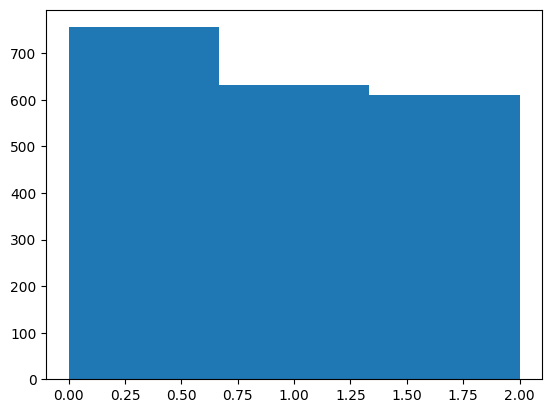

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    data = t.to(device)
    out =  model(data.x, data.edge_index, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))
    if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
data.x.size(0)

22

# AttentiveFP with Edge Features Training

In [ ]:
batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device)
print("Data x device:", data.x.device)
print("Data edge_index device:", data.edge_index.device)
print("Data edge_attr device:", data.edge_attr.device)
print("Batch device:", batch.device)

Data x device: cuda:0
Data edge_index device: cuda:0
Data edge_attr device: cuda:0
Batch device: cuda:0


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 1900/1900 [00:36<00:00, 51.83it/s]


Epoch: 001, Average MAE: 2.28627
Validation MAE: 2.65858


100%|██████████| 1900/1900 [00:34<00:00, 54.95it/s]


Epoch: 002, Average MAE: 2.07751
Validation MAE: 2.43465


100%|██████████| 1900/1900 [00:34<00:00, 55.41it/s]


Epoch: 003, Average MAE: 1.94892
Validation MAE: 2.60339


100%|██████████| 1900/1900 [00:34<00:00, 55.26it/s]


Epoch: 004, Average MAE: 1.88381
Validation MAE: 2.30491


100%|██████████| 1900/1900 [00:34<00:00, 54.64it/s]


Epoch: 005, Average MAE: 1.82329
Validation MAE: 2.26684


100%|██████████| 1900/1900 [00:34<00:00, 54.51it/s]


Epoch: 006, Average MAE: 1.72628
Validation MAE: 2.25792


100%|██████████| 1900/1900 [00:35<00:00, 54.03it/s]


Epoch: 007, Average MAE: 1.75493
Validation MAE: 2.18063


100%|██████████| 1900/1900 [00:35<00:00, 53.90it/s]


Epoch: 008, Average MAE: 1.70654
Validation MAE: 2.17976


100%|██████████| 1900/1900 [00:34<00:00, 55.67it/s]


Epoch: 009, Average MAE: 1.62180
Validation MAE: 2.06170


100%|██████████| 1900/1900 [00:33<00:00, 56.65it/s]


Epoch: 010, Average MAE: 1.59089
Validation MAE: 2.31470


100%|██████████| 1900/1900 [00:34<00:00, 55.78it/s]


Epoch: 011, Average MAE: 1.61654
Validation MAE: 1.91234


100%|██████████| 1900/1900 [00:34<00:00, 55.78it/s]


Epoch: 012, Average MAE: 1.58546
Validation MAE: 2.20706


100%|██████████| 1900/1900 [00:33<00:00, 56.06it/s]


Epoch: 013, Average MAE: 1.93259
Validation MAE: 2.26918


100%|██████████| 1900/1900 [00:35<00:00, 54.18it/s]


Epoch: 014, Average MAE: 1.61346
Validation MAE: 2.00220


100%|██████████| 1900/1900 [00:34<00:00, 55.17it/s]


Epoch: 015, Average MAE: 1.67116
Validation MAE: 2.28591


100%|██████████| 1900/1900 [00:35<00:00, 53.13it/s]


Epoch: 016, Average MAE: 1.62723
Validation MAE: 1.95602
Early stopping triggered.
Test MAE: 1.73615


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 1900/1900 [00:35<00:00, 54.20it/s]


Epoch: 001, Average MAE: 2.58832
Validation MAE: 2.23652


100%|██████████| 1900/1900 [00:34<00:00, 55.82it/s]


Epoch: 002, Average MAE: 2.37303
Validation MAE: 1.96590


100%|██████████| 1900/1900 [00:34<00:00, 55.64it/s]


Epoch: 003, Average MAE: 2.23817
Validation MAE: 2.00218


100%|██████████| 1900/1900 [00:33<00:00, 56.15it/s]


Epoch: 004, Average MAE: 2.10226
Validation MAE: 1.77761


100%|██████████| 1900/1900 [00:33<00:00, 56.25it/s]


Epoch: 005, Average MAE: 2.05996
Validation MAE: 1.76992


100%|██████████| 1900/1900 [00:33<00:00, 56.98it/s]


Epoch: 006, Average MAE: 2.01351
Validation MAE: 1.62056


100%|██████████| 1900/1900 [00:33<00:00, 56.52it/s]


Epoch: 007, Average MAE: 1.90358
Validation MAE: 1.73315


100%|██████████| 1900/1900 [00:34<00:00, 55.00it/s]


Epoch: 008, Average MAE: 1.90072
Validation MAE: 1.56338


100%|██████████| 1900/1900 [00:34<00:00, 55.31it/s]


Epoch: 009, Average MAE: 1.92971
Validation MAE: 1.60514


100%|██████████| 1900/1900 [00:34<00:00, 55.45it/s]


Epoch: 010, Average MAE: 1.76356
Validation MAE: 1.58469


100%|██████████| 1900/1900 [00:35<00:00, 53.62it/s]


Epoch: 011, Average MAE: 1.67738
Validation MAE: 2.37662


100%|██████████| 1900/1900 [00:36<00:00, 52.60it/s]


Epoch: 012, Average MAE: 1.67745
Validation MAE: 1.43579


100%|██████████| 1900/1900 [00:35<00:00, 52.97it/s]


Epoch: 013, Average MAE: 1.60871
Validation MAE: 1.39462


100%|██████████| 1900/1900 [00:34<00:00, 55.39it/s]


Epoch: 014, Average MAE: 1.60697
Validation MAE: 1.47260


100%|██████████| 1900/1900 [00:33<00:00, 56.69it/s]


Epoch: 015, Average MAE: 1.50000
Validation MAE: 1.48383


100%|██████████| 1900/1900 [00:34<00:00, 55.50it/s]


Epoch: 016, Average MAE: 1.89802
Validation MAE: 2.02080


100%|██████████| 1900/1900 [00:33<00:00, 57.24it/s]


Epoch: 017, Average MAE: 1.78003
Validation MAE: 1.47221


100%|██████████| 1900/1900 [00:33<00:00, 57.52it/s]


Epoch: 018, Average MAE: 1.51643
Validation MAE: 1.46965
Early stopping triggered.
Test MAE: 1.55539


In [ ]:
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


Test MAE: 0.02019


# Proposed new architecture

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 1900/1900 [00:31<00:00, 59.42it/s]


Epoch: 001, Average MAE: 2.31027
Validation MAE: 2.75206


100%|██████████| 1900/1900 [00:29<00:00, 63.90it/s]


Epoch: 002, Average MAE: 2.15914
Validation MAE: 2.62723


100%|██████████| 1900/1900 [00:29<00:00, 63.57it/s]


Epoch: 003, Average MAE: 2.09892
Validation MAE: 2.53519


100%|██████████| 1900/1900 [00:30<00:00, 63.03it/s]


Epoch: 004, Average MAE: 1.97871
Validation MAE: 2.47611


100%|██████████| 1900/1900 [00:30<00:00, 62.05it/s]


Epoch: 005, Average MAE: 1.92471
Validation MAE: 2.70069


100%|██████████| 1900/1900 [00:30<00:00, 61.51it/s]


Epoch: 006, Average MAE: 1.93344
Validation MAE: 2.42635


100%|██████████| 1900/1900 [00:31<00:00, 60.41it/s]


Epoch: 007, Average MAE: 1.85625
Validation MAE: 2.37505


100%|██████████| 1900/1900 [00:31<00:00, 60.31it/s]


Epoch: 008, Average MAE: 1.83917
Validation MAE: 2.38450


100%|██████████| 1900/1900 [00:30<00:00, 62.14it/s]


Epoch: 009, Average MAE: 1.81451
Validation MAE: 2.41327


100%|██████████| 1900/1900 [00:30<00:00, 62.48it/s]


Epoch: 010, Average MAE: 1.78228
Validation MAE: 2.31284


100%|██████████| 1900/1900 [00:31<00:00, 61.16it/s]


Epoch: 011, Average MAE: 1.74990
Validation MAE: 2.33394


100%|██████████| 1900/1900 [00:30<00:00, 61.75it/s]


Epoch: 012, Average MAE: 1.69920
Validation MAE: 2.22759


100%|██████████| 1900/1900 [00:32<00:00, 59.13it/s]


Epoch: 013, Average MAE: 1.70625
Validation MAE: 2.43220


100%|██████████| 1900/1900 [00:32<00:00, 58.94it/s]


Epoch: 014, Average MAE: 1.75724
Validation MAE: 2.34100


100%|██████████| 1900/1900 [00:31<00:00, 59.87it/s]


Epoch: 015, Average MAE: 1.66868
Validation MAE: 2.20905


100%|██████████| 1900/1900 [00:30<00:00, 61.73it/s]


Epoch: 016, Average MAE: 1.60519
Validation MAE: 2.08768


100%|██████████| 1900/1900 [00:31<00:00, 59.72it/s]


Epoch: 017, Average MAE: 1.58890
Validation MAE: 2.13052


100%|██████████| 1900/1900 [00:30<00:00, 62.40it/s]


Epoch: 018, Average MAE: 1.53103
Validation MAE: 1.99545


100%|██████████| 1900/1900 [00:30<00:00, 61.79it/s]


Epoch: 019, Average MAE: 1.48431
Validation MAE: 2.05491


100%|██████████| 1900/1900 [00:30<00:00, 61.61it/s]


Epoch: 020, Average MAE: 1.49731
Validation MAE: 1.97387
Test MAE: 1.71630


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 1900/1900 [00:42<00:00, 44.19it/s]


Epoch: 001, Average MAE: 2.55740
Validation MAE: 2.16319


100%|██████████| 1900/1900 [00:41<00:00, 46.07it/s]


Epoch: 002, Average MAE: 2.36328
Validation MAE: 1.96958


100%|██████████| 1900/1900 [00:44<00:00, 43.13it/s]


Epoch: 003, Average MAE: 2.24844
Validation MAE: 1.91169


100%|██████████| 1900/1900 [00:44<00:00, 42.28it/s]


Epoch: 004, Average MAE: 2.18214
Validation MAE: 1.87142


100%|██████████| 1900/1900 [00:44<00:00, 42.94it/s]


Epoch: 005, Average MAE: 2.08860
Validation MAE: 2.04773


100%|██████████| 1900/1900 [00:44<00:00, 42.58it/s]


Epoch: 006, Average MAE: 2.03734
Validation MAE: 1.69043


100%|██████████| 1900/1900 [00:43<00:00, 43.90it/s]


Epoch: 007, Average MAE: 1.95420
Validation MAE: 1.77980


100%|██████████| 1900/1900 [00:45<00:00, 41.92it/s]


Epoch: 008, Average MAE: 1.86566
Validation MAE: 1.54388


100%|██████████| 1900/1900 [00:44<00:00, 42.69it/s]


Epoch: 009, Average MAE: 1.73050
Validation MAE: 1.62706


100%|██████████| 1900/1900 [00:44<00:00, 43.05it/s]


Epoch: 010, Average MAE: 1.63665
Validation MAE: 1.43829


100%|██████████| 1900/1900 [00:44<00:00, 42.50it/s]


Epoch: 011, Average MAE: 1.65011
Validation MAE: 1.61382


100%|██████████| 1900/1900 [00:45<00:00, 41.87it/s]


Epoch: 012, Average MAE: 1.63665
Validation MAE: 1.37599


100%|██████████| 1900/1900 [00:47<00:00, 40.38it/s]


Epoch: 013, Average MAE: 1.59954
Validation MAE: 1.51327


100%|██████████| 1900/1900 [00:45<00:00, 42.09it/s]


Epoch: 014, Average MAE: 1.56359
Validation MAE: 1.43384


100%|██████████| 1900/1900 [00:44<00:00, 42.72it/s]


Epoch: 015, Average MAE: 1.63790
Validation MAE: 1.41333


100%|██████████| 1900/1900 [00:44<00:00, 42.87it/s]


Epoch: 016, Average MAE: 1.54214
Validation MAE: 1.59386


100%|██████████| 1900/1900 [00:45<00:00, 42.18it/s]


Epoch: 017, Average MAE: 1.60376
Validation MAE: 1.44538
Early stopping triggered.
Test MAE: 1.46003


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 1900/1900 [00:34<00:00, 55.05it/s]


Epoch: 001, Average MAE: 2.51830
Validation MAE: 2.09994


100%|██████████| 1900/1900 [00:32<00:00, 58.93it/s]


Epoch: 002, Average MAE: 2.36492
Validation MAE: 2.06528


100%|██████████| 1900/1900 [00:33<00:00, 57.01it/s]


Epoch: 003, Average MAE: 2.39304
Validation MAE: 1.92388


100%|██████████| 1900/1900 [00:33<00:00, 57.54it/s]


Epoch: 004, Average MAE: 2.25737
Validation MAE: 1.83519


100%|██████████| 1900/1900 [00:32<00:00, 57.94it/s]


Epoch: 005, Average MAE: 2.19016
Validation MAE: 1.79237


100%|██████████| 1900/1900 [00:32<00:00, 58.87it/s]


Epoch: 006, Average MAE: 2.11083
Validation MAE: 1.88865


100%|██████████| 1900/1900 [00:32<00:00, 59.09it/s]


Epoch: 007, Average MAE: 2.26638
Validation MAE: 2.04351


100%|██████████| 1900/1900 [00:31<00:00, 59.48it/s]


Epoch: 008, Average MAE: 2.12054
Validation MAE: 1.74315


100%|██████████| 1900/1900 [00:32<00:00, 58.53it/s]


Epoch: 009, Average MAE: 1.98500
Validation MAE: 1.86008


100%|██████████| 1900/1900 [00:31<00:00, 60.34it/s]


Epoch: 010, Average MAE: 1.89674
Validation MAE: 1.60660


100%|██████████| 1900/1900 [00:32<00:00, 58.54it/s]


Epoch: 011, Average MAE: 1.82288
Validation MAE: 1.61284


100%|██████████| 1900/1900 [00:31<00:00, 60.32it/s]


Epoch: 012, Average MAE: 1.70637
Validation MAE: 1.54779


100%|██████████| 1900/1900 [00:30<00:00, 61.34it/s]


Epoch: 013, Average MAE: 1.65584
Validation MAE: 1.43947


100%|██████████| 1900/1900 [00:31<00:00, 60.08it/s]


Epoch: 014, Average MAE: 1.57366
Validation MAE: 1.30272


100%|██████████| 1900/1900 [00:31<00:00, 60.98it/s]


Epoch: 015, Average MAE: 1.53315
Validation MAE: 1.28766


100%|██████████| 1900/1900 [00:31<00:00, 60.36it/s]


Epoch: 016, Average MAE: 1.63625
Validation MAE: 1.23703


100%|██████████| 1900/1900 [00:32<00:00, 59.22it/s]


Epoch: 017, Average MAE: 1.40852
Validation MAE: 1.29505


100%|██████████| 1900/1900 [00:31<00:00, 60.34it/s]


Epoch: 018, Average MAE: 1.41947
Validation MAE: 1.38161


100%|██████████| 1900/1900 [00:31<00:00, 59.41it/s]


Epoch: 019, Average MAE: 1.49975
Validation MAE: 1.25863


100%|██████████| 1900/1900 [00:31<00:00, 60.36it/s]


Epoch: 020, Average MAE: 1.61780
Validation MAE: 1.39766
Test MAE: 1.58970


In [ ]:
avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


Test MAE: 0.02103


In [ ]:
import torch
import random
from tqdm import tqdm


# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 1900/1900 [00:37<00:00, 50.43it/s]


Epoch: 000, Average loss: 0.00551, Accuracy: 0.99947
Validation Loss: 0.00003, Validation Accuracy: 1.00000
Model improved! Saving model...


100%|██████████| 1900/1900 [00:38<00:00, 49.31it/s]


Epoch: 001, Average loss: 0.00002, Accuracy: 1.00000
Validation Loss: 0.00001, Validation Accuracy: 1.00000
Model improved! Saving model...


100%|██████████| 1900/1900 [00:39<00:00, 48.60it/s]


Epoch: 002, Average loss: 0.00002, Accuracy: 1.00000
Validation Loss: 0.00001, Validation Accuracy: 1.00000
No improvement.


100%|██████████| 1900/1900 [00:39<00:00, 47.85it/s]


Epoch: 003, Average loss: 0.00002, Accuracy: 1.00000
Validation Loss: 0.00004, Validation Accuracy: 1.00000
No improvement.


100%|██████████| 1900/1900 [00:39<00:00, 48.62it/s]


Epoch: 004, Average loss: 0.00002, Accuracy: 1.00000
Validation Loss: 0.00001, Validation Accuracy: 1.00000
Model improved! Saving model...


100%|██████████| 1900/1900 [00:41<00:00, 45.79it/s]


Epoch: 005, Average loss: 0.00002, Accuracy: 1.00000
Validation Loss: 0.00001, Validation Accuracy: 1.00000
No improvement.


100%|██████████| 1900/1900 [00:45<00:00, 41.39it/s]


Epoch: 006, Average loss: 0.00002, Accuracy: 1.00000
Validation Loss: 0.00006, Validation Accuracy: 1.00000
No improvement.


100%|██████████| 1900/1900 [00:48<00:00, 38.96it/s]


Epoch: 007, Average loss: 0.00002, Accuracy: 1.00000
Validation Loss: 0.00002, Validation Accuracy: 1.00000
No improvement.


 79%|███████▊  | 1494/1900 [00:37<00:10, 40.11it/s]


KeyboardInterrupt: 

In [ ]:
# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
# model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))

Test Loss: 0.83902, Test Accuracy: 1.00000


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
CUDA_LAUNCH_BLOCKING=1
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:26<00:00, 69.54it/s]


Epoch: 000, Average loss: 0.85077, Accuracy: 0.61379
Validation Loss: 0.68999, Validation Accuracy: 0.70090
Model improved! Saving model...


100%|██████████| 5989/5989 [01:20<00:00, 74.35it/s]


Epoch: 001, Average loss: 0.67507, Accuracy: 0.71147
Validation Loss: 0.74277, Validation Accuracy: 0.68186
No improvement.


100%|██████████| 5989/5989 [01:19<00:00, 75.06it/s]


Epoch: 002, Average loss: 0.62121, Accuracy: 0.73201
Validation Loss: 0.58771, Validation Accuracy: 0.75351
Model improved! Saving model...


100%|██████████| 5989/5989 [01:21<00:00, 73.63it/s]


Epoch: 003, Average loss: 0.59840, Accuracy: 0.74487
Validation Loss: 0.57700, Validation Accuracy: 0.75802
Model improved! Saving model...


100%|██████████| 5989/5989 [01:19<00:00, 75.68it/s]


Epoch: 004, Average loss: 0.57462, Accuracy: 0.75689
Validation Loss: 0.59203, Validation Accuracy: 0.75451
No improvement.


100%|██████████| 5989/5989 [01:21<00:00, 73.33it/s]


Epoch: 005, Average loss: 0.57065, Accuracy: 0.75739
Validation Loss: 0.55757, Validation Accuracy: 0.76353
Model improved! Saving model...


100%|██████████| 5989/5989 [01:19<00:00, 75.34it/s]


Epoch: 006, Average loss: 0.56141, Accuracy: 0.76724
Validation Loss: 0.60380, Validation Accuracy: 0.72745
No improvement.


100%|██████████| 5989/5989 [01:21<00:00, 73.60it/s]


Epoch: 007, Average loss: 0.55616, Accuracy: 0.76691
Validation Loss: 0.56383, Validation Accuracy: 0.75752
No improvement.


100%|██████████| 5989/5989 [01:20<00:00, 74.37it/s]


Epoch: 008, Average loss: 0.54910, Accuracy: 0.76674
Validation Loss: 0.57712, Validation Accuracy: 0.76052
No improvement.


100%|██████████| 5989/5989 [01:19<00:00, 75.11it/s]


Epoch: 009, Average loss: 0.53870, Accuracy: 0.77609
Validation Loss: 0.59208, Validation Accuracy: 0.73297
No improvement.


100%|██████████| 5989/5989 [01:23<00:00, 72.15it/s]


Epoch: 010, Average loss: 0.54117, Accuracy: 0.77208
Validation Loss: 0.56655, Validation Accuracy: 0.76202
No improvement.


100%|██████████| 5989/5989 [01:23<00:00, 72.00it/s]


Epoch: 011, Average loss: 0.53967, Accuracy: 0.77409
Validation Loss: 0.54259, Validation Accuracy: 0.77705
Model improved! Saving model...


100%|██████████| 5989/5989 [01:22<00:00, 72.85it/s]


Epoch: 012, Average loss: 0.53608, Accuracy: 0.76707
Validation Loss: 0.54477, Validation Accuracy: 0.76954
No improvement.


100%|██████████| 5989/5989 [01:21<00:00, 73.81it/s]


Epoch: 013, Average loss: 0.52757, Accuracy: 0.77425
Validation Loss: 0.54618, Validation Accuracy: 0.77104
No improvement.


100%|██████████| 5989/5989 [01:20<00:00, 74.28it/s]


Epoch: 014, Average loss: 0.52578, Accuracy: 0.77826
Validation Loss: 0.55329, Validation Accuracy: 0.77505
No improvement.


100%|██████████| 5989/5989 [01:25<00:00, 69.88it/s]


Epoch: 015, Average loss: 0.51995, Accuracy: 0.78477
Validation Loss: 0.56865, Validation Accuracy: 0.76754
No improvement.


100%|██████████| 5989/5989 [01:22<00:00, 72.56it/s]


Epoch: 016, Average loss: 0.51970, Accuracy: 0.78193
Validation Loss: 0.55099, Validation Accuracy: 0.76603
No improvement.


100%|██████████| 5989/5989 [01:22<00:00, 72.75it/s]


Epoch: 017, Average loss: 0.51853, Accuracy: 0.78694
Validation Loss: 0.57027, Validation Accuracy: 0.75852
No improvement.


100%|██████████| 5989/5989 [01:24<00:00, 71.19it/s]


Epoch: 018, Average loss: 0.51247, Accuracy: 0.78060
Validation Loss: 0.55355, Validation Accuracy: 0.77104
No improvement.


100%|██████████| 5989/5989 [01:22<00:00, 72.39it/s]


Epoch: 019, Average loss: 0.51177, Accuracy: 0.78527
Validation Loss: 0.53661, Validation Accuracy: 0.77906
Model improved! Saving model...
Test Loss: 0.50733, Test Accuracy: 0.80120


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
CUDA_LAUNCH_BLOCKING=1
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:11<00:00, 84.16it/s]


Epoch: 000, Average loss: 0.85436, Accuracy: 0.60778
Validation Loss: 0.74178, Validation Accuracy: 0.65681
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 89.11it/s]


Epoch: 001, Average loss: 0.64916, Accuracy: 0.71548
Validation Loss: 0.73019, Validation Accuracy: 0.67134
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.88it/s]


Epoch: 002, Average loss: 0.60810, Accuracy: 0.73668
Validation Loss: 0.64961, Validation Accuracy: 0.72094
Model improved! Saving model...


100%|██████████| 5989/5989 [01:06<00:00, 89.82it/s]


Epoch: 003, Average loss: 0.58794, Accuracy: 0.74720
Validation Loss: 0.63767, Validation Accuracy: 0.72846
Model improved! Saving model...


100%|██████████| 5989/5989 [01:06<00:00, 89.87it/s]


Epoch: 004, Average loss: 0.56584, Accuracy: 0.76340
Validation Loss: 0.65949, Validation Accuracy: 0.70942
No improvement.


100%|██████████| 5989/5989 [01:05<00:00, 90.81it/s]


Epoch: 005, Average loss: 0.55449, Accuracy: 0.76056
Validation Loss: 0.60995, Validation Accuracy: 0.73747
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.75it/s]


Epoch: 006, Average loss: 0.55171, Accuracy: 0.76089
Validation Loss: 0.61828, Validation Accuracy: 0.74198
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 89.02it/s]


Epoch: 007, Average loss: 0.53734, Accuracy: 0.77225
Validation Loss: 0.61481, Validation Accuracy: 0.73597
No improvement.


100%|██████████| 5989/5989 [01:06<00:00, 89.81it/s]


Epoch: 008, Average loss: 0.52516, Accuracy: 0.77926
Validation Loss: 0.57212, Validation Accuracy: 0.76303
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.75it/s]


Epoch: 009, Average loss: 0.51602, Accuracy: 0.78143
Validation Loss: 0.59689, Validation Accuracy: 0.75301
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 88.17it/s]


Epoch: 010, Average loss: 0.51498, Accuracy: 0.78160
Validation Loss: 0.59276, Validation Accuracy: 0.75852
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.89it/s]


Epoch: 011, Average loss: 0.52642, Accuracy: 0.77793
Validation Loss: 0.60376, Validation Accuracy: 0.76904
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.92it/s]


Epoch: 012, Average loss: 0.51168, Accuracy: 0.78728
Validation Loss: 0.56862, Validation Accuracy: 0.76453
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 88.05it/s]


Epoch: 013, Average loss: 0.50189, Accuracy: 0.78310
Validation Loss: 0.61160, Validation Accuracy: 0.75200
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 88.19it/s]


Epoch: 014, Average loss: 0.49787, Accuracy: 0.79496
Validation Loss: 0.60499, Validation Accuracy: 0.76653
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 88.05it/s]


Epoch: 015, Average loss: 0.49510, Accuracy: 0.79245
Validation Loss: 0.57490, Validation Accuracy: 0.76854
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.95it/s]


Epoch: 016, Average loss: 0.49007, Accuracy: 0.79279
Validation Loss: 0.57761, Validation Accuracy: 0.75852
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 88.39it/s]


Epoch: 017, Average loss: 0.48619, Accuracy: 0.79563
Validation Loss: 0.56819, Validation Accuracy: 0.77204
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.45it/s]


Epoch: 018, Average loss: 0.48783, Accuracy: 0.79663
Validation Loss: 0.57474, Validation Accuracy: 0.75100
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.40it/s]


Epoch: 019, Average loss: 0.47551, Accuracy: 0.79846
Validation Loss: 0.59259, Validation Accuracy: 0.76102
No improvement.
Test Loss: 0.53733, Test Accuracy: 0.78117


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
CUDA_LAUNCH_BLOCKING=1
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:19<00:00, 74.93it/s]


Epoch: 000, Average loss: 0.82706, Accuracy: 0.62765
Validation Loss: 0.77245, Validation Accuracy: 0.66283
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 77.79it/s]


Epoch: 001, Average loss: 0.64119, Accuracy: 0.72366
Validation Loss: 0.64681, Validation Accuracy: 0.72545
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.60it/s]


Epoch: 002, Average loss: 0.60780, Accuracy: 0.74086
Validation Loss: 0.59995, Validation Accuracy: 0.75000
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.68it/s]


Epoch: 003, Average loss: 0.57781, Accuracy: 0.75405
Validation Loss: 0.65299, Validation Accuracy: 0.71894
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.08it/s]


Epoch: 004, Average loss: 0.56418, Accuracy: 0.75906
Validation Loss: 0.61743, Validation Accuracy: 0.72695
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.76it/s]


Epoch: 005, Average loss: 0.55040, Accuracy: 0.76824
Validation Loss: 0.58008, Validation Accuracy: 0.75000
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.69it/s]


Epoch: 006, Average loss: 0.53890, Accuracy: 0.77642
Validation Loss: 0.57799, Validation Accuracy: 0.75651
Model improved! Saving model...


100%|██████████| 5989/5989 [01:15<00:00, 78.94it/s]


Epoch: 007, Average loss: 0.53069, Accuracy: 0.78210
Validation Loss: 0.57792, Validation Accuracy: 0.76754
Model improved! Saving model...


100%|██████████| 5989/5989 [01:17<00:00, 77.56it/s]


Epoch: 008, Average loss: 0.52230, Accuracy: 0.78761
Validation Loss: 0.55527, Validation Accuracy: 0.76804
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.62it/s]


Epoch: 009, Average loss: 0.51634, Accuracy: 0.78210
Validation Loss: 0.59114, Validation Accuracy: 0.75701
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.10it/s]


Epoch: 010, Average loss: 0.50713, Accuracy: 0.78327
Validation Loss: 0.58000, Validation Accuracy: 0.75802
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.26it/s]


Epoch: 011, Average loss: 0.50051, Accuracy: 0.79162
Validation Loss: 0.57951, Validation Accuracy: 0.76503
No improvement.


100%|██████████| 5989/5989 [01:17<00:00, 77.71it/s]


Epoch: 012, Average loss: 0.49515, Accuracy: 0.79279
Validation Loss: 0.57201, Validation Accuracy: 0.77154
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.05it/s]


Epoch: 013, Average loss: 0.49333, Accuracy: 0.79262
Validation Loss: 0.55736, Validation Accuracy: 0.77455
No improvement.


100%|██████████| 5989/5989 [01:18<00:00, 76.75it/s]


Epoch: 014, Average loss: 0.49008, Accuracy: 0.79663
Validation Loss: 0.56211, Validation Accuracy: 0.76202
No improvement.


100%|██████████| 5989/5989 [01:17<00:00, 77.06it/s]


Epoch: 015, Average loss: 0.48785, Accuracy: 0.79679
Validation Loss: 0.55073, Validation Accuracy: 0.76804
Model improved! Saving model...


100%|██████████| 5989/5989 [01:18<00:00, 76.13it/s]


Epoch: 016, Average loss: 0.48828, Accuracy: 0.79279
Validation Loss: 0.56119, Validation Accuracy: 0.76603
No improvement.


100%|██████████| 5989/5989 [01:18<00:00, 76.55it/s]


Epoch: 017, Average loss: 0.47811, Accuracy: 0.80681
Validation Loss: 0.57704, Validation Accuracy: 0.76754
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.10it/s]


Epoch: 018, Average loss: 0.48195, Accuracy: 0.79813
Validation Loss: 0.54990, Validation Accuracy: 0.77856
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.71it/s]


Epoch: 019, Average loss: 0.47356, Accuracy: 0.80314
Validation Loss: 0.55569, Validation Accuracy: 0.77655
No improvement.
Test Loss: 0.53218, Test Accuracy: 0.77967


In [ ]:
out.shape

torch.Size([1, 3])

In [ ]:
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))

RuntimeError: Error(s) in loading state_dict for AttentiveFP:
	Missing key(s) in state_dict: "atom_convs.0.att", "atom_convs.0.lin_l.weight", "atom_convs.0.lin_l.bias", "atom_convs.0.lin_r.weight", "atom_convs.0.lin_r.bias", "atom_convs.1.att", "atom_convs.1.lin_l.weight", "atom_convs.1.lin_l.bias", "atom_convs.1.lin_r.weight", "atom_convs.1.lin_r.bias", "mol_conv.att", "mol_conv.lin_l.weight", "mol_conv.lin_l.bias", "mol_conv.lin_r.weight", "mol_conv.lin_r.bias". 
	Unexpected key(s) in state_dict: "atom_convs.0.att_src", "atom_convs.0.att_dst", "atom_convs.0.lin.weight", "atom_convs.1.att_src", "atom_convs.1.att_dst", "atom_convs.1.lin.weight", "mol_conv.att_src", "mol_conv.att_dst", "mol_conv.lin.weight". 
	size mismatch for atom_convs.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for atom_convs.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for mol_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

# AttentiveFP with Edge Features Training and with explicit H

In [ ]:
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index,  data.edge_attr, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')  # Optionally save the model here
        # torch.save(model.state_dict(), 'best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement


In [ ]:
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    data = t.to(device)
    out =  model(data.x, data.edge_index, data.edge_attr, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))
    if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test SMILES string
def evaluate_smiles(smiles_string):
    classes = ['insoluble', 'slightly soluble', 'soluble']
    G = read_smiles(smiles_string, explicit_hydrogen=True) #decode smiles string
    feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1]) #convert element to one-hot vector
    edges = np.asarray(G.edges) #get edge array
    index = np.asarray([edges[:,0], edges[:,1]]) #reformat edge array to torch geometric suitable format
    d = Data(x=torch.tensor(feature, dtype=torch.float),edge_index=torch.tensor(index, dtype=torch.long)) #create torch gemoetry Data object
    data = d.to(device) #send data to device memory
    model.eval() #set model to evaluate mode
    print(classes[torch.argmax(torch.softmax(model(data), dim=0)).item()]) #evaluate the test data

In [ ]:
evaluate_smiles('C(C(C1C(=C(C(=O)O1)O)O)O)O') #test out the model on Vitamin C